In [13]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import torch
import requests
from PIL import Image
from transformers import BlipProcessor, BlipForImageTextRetrieval


from datasets import load_dataset

test_ds = load_dataset("zai-org/VisionRewardDB-Image", split='train[40000:]')


import torch
from transformers import PreTrainedModel, PretrainedConfig

processor = BlipProcessor.from_pretrained("Salesforce/blip-itm-base-coco")
backbone = BlipForImageTextRetrieval.from_pretrained("Salesforce/blip-itm-base-coco", torch_dtype=torch.float16)




class Rater(PreTrainedModel):
    def __init__(self, config):
      super().__init__(PretrainedConfig())
      self.backbone = backbone 
      # self.t_score = 0.2
      # self.t_ce = 0.2
      self.t = torch.nn.Parameter(torch.tensor(0.2))

    def forward(self, pixel_values, input_ids, attention_mask, n_images, labels=None):
      n_images = n_images[0]
      outputs = self.backbone(pixel_values=pixel_values, input_ids=input_ids, attention_mask=attention_mask)
      itm_scores = outputs[0]

      if labels is not None:
        assert itm_scores.shape[0] == labels.shape[0] == n_images, f"{itm_scores.shape[0]} {labels.shape[0]} {n_images}"
        assert itm_scores.shape[1] == labels.shape[1] == 2
        bce_loss = torch.nn.functional.cross_entropy(itm_scores, labels.argmax(-1)) 
        loss = bce_loss

        assert itm_scores.argmax(-1).shape == labels.argmax(-1).shape
        outputs['loss'] = loss

      return outputs
    
model = Rater.from_pretrained("weathon/BLIP-Reward", config=PretrainedConfig())
model = model.cuda()

from datasets import load_dataset

import io, math, random
import numpy as np
from PIL import Image, ImageFilter, ImageEnhance
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

import pandas as pd

df = pd.read_csv("rules.csv")

import pandas as pd
import re

df.columns = df.columns.str.strip()
df['Dimension'] = df['Dimension'].ffill()

df['dim_key'] = df['Dimension'].apply(lambda x: re.search(r'\((.*?)\)', x).group(1) if re.search(r'\((.*?)\)', x) else x)

guide = {
    dim_key: {
        int(row['Score']): row['Option'] + ": " +str(row['Description']).strip()
        for _, row in group.iterrows()
    }
    for dim_key, group in df.groupby('dim_key')
}


dims = {k: v for k, v in guide.items() if k not in ["unsafe type", "hands", "face", "body", "safety", "lighting aesthetic"]}.keys()
dims = list(dims)
dim_min = {i:min(guide[i].keys()) for i in guide.keys()}

import json
with open("prompts.json", "r") as f:
    prompt_dict = json.load(f)


In [14]:
def format_data(sample, dim):
    images = sample["image"]
    dims_selected = [dim]

    prompts = [prompt_dict[dim] for i, dim in enumerate(dims_selected)]
    n_images = len(images)
    n_prompts = len(prompts)
    inputs = processor(images=images, text=prompts, return_tensors="pt", padding=True)
    answers = [1 if i[dim]<0 else 0 for i, dim in zip(sample["annotation"], dims_selected)]
    answers = [(1-i, i) for i in answers]
    labels = torch.tensor(answers)
    inputs['labels'] = labels
    inputs['dim'] = [dims.index(dim) for dim in dims_selected]
    inputs['n_images'] = [n_images] * len(inputs['input_ids'])
    return {
        'pixel_values': inputs['pixel_values'],
        'input_ids': inputs['input_ids'],
        'attention_mask': inputs['attention_mask'],
        'labels': inputs['labels'], 
        'n_images': inputs['n_images'],
    } 


In [15]:
import tqdm
from sklearn.metrics import f1_score, roc_auc_score

pred = []
gt = []
recorded_dims = []

pbar = tqdm.tqdm(range(len(test_ds)))
for i in pbar: 
    for dim in dims:
        inputs = format_data(test_ds[i:i+1], dim)
        outputs = model(
            pixel_values=inputs['pixel_values'].cuda(), 
            input_ids=inputs['input_ids'].cuda(), 
            attention_mask=inputs['attention_mask'].cuda(), 
            n_images=inputs['n_images'], 
            labels=inputs['labels'].cuda()
        )
        score = torch.nn.functional.softmax(outputs['itm_score'], dim=-1)[0,1].item()
        pred.append(score)
        gt.append(inputs['labels'][0,1].item())
        recorded_dims.append(dim)
        f1 = f1_score(gt, [1 if p > 0.5 else 0 for p in pred])
        auc = roc_auc_score(gt, pred)
        pbar.set_description(f"F1: {f1:.4f} AUC: {auc:.4f}")


  0%|          | 0/743 [00:00<?, ?it/s]/home/wg25r/miniconda/envs/neg/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/wg25r/miniconda/envs/neg/lib/python3.10/site-packages/sklearn/metrics/_ranking.py:424: UndefinedMetricWarning: Only one class is present in y_true. ROC AUC score is not defined in that case.
  warnings.warn(
F1: 0.0000 AUC: nan:   0%|          | 0/743 [00:00<?, ?it/s]/home/wg25r/miniconda/envs/neg/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1731: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no true nor predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", result.shape[0])
/home/w

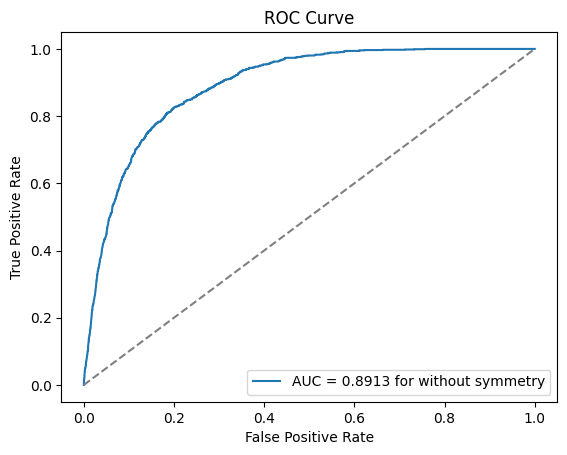

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# assume gt = true labels (0 or 1), pred = predicted probabilities for positive class
selected_gt = [g for g, d in zip(gt, recorded_dims) if d != dims[11]]
selected_pred = [p for p, d in zip(pred, recorded_dims) if d != dims[11]]

fpr, tpr, _ = roc_curve(selected_gt, selected_pred)
auc = roc_auc_score(selected_gt, selected_pred)

plt.plot(fpr, tpr, label=f"AUC = {auc:.4f} for without {dims[11]}")
plt.plot([0,1], [0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()


In [44]:
import torch
from diffusers import StableDiffusion3Pipeline

pipe = StableDiffusion3Pipeline.from_pretrained("stabilityai/stable-diffusion-3.5-large", torch_dtype=torch.bfloat16)
pipe = pipe.to("cuda")

In [ ]:

image_original = pipe(
    "A bathroom that is very clean and nice.",
    num_inference_steps=28,
    guidance_scale=3.5,
).images[0]
image_original


  0%|          | 0/28 [00:00<?, ?it/s]

In [ ]:
image_distorted = pipe(
    "A bathroom that is very clean and nice.",
    num_inference_steps=28,
    guidance_scale=3.5,
).images[0]

In [4]:
for dim in dims:
    inputs = processor(images=[Image.open("gpt3.png")], text=[prompt_dict[dim]] * 1, return_tensors="pt", padding=True).to("cuda")
    outputs = model(**inputs, n_images=[2]) 
    score = torch.nn.functional.softmax(outputs['itm_score'], dim=-1)[:,1]
    print(f"{dim}: {list(score.cpu().detach().numpy())}") 

background: [np.float16(0.03079)]
clarity: [np.float16(0.05655)]
color aesthetic: [np.float16(0.4358)]
color brightness: [np.float16(0.00324)]
detail realism: [np.float16(0.6357)]
detail refinement: [np.float16(0.5894)]
emotion: [np.float16(0.03842)]
lighting distinction: [np.float16(0.09467)]
main object: [np.float16(0.8687)]
object pairing: [np.float16(0.10223)]
richness: [np.float16(0.00888)]
symmetry: [np.float16(0.0107)]
